In [1]:
## NEED TO RUN THIS TO GET CHOLMOD TO WORK
import ctypes

CUDA_LIB = "/share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib"
OPENBLAS = "/share/software/user/open/openblas/0.3.20/lib"
SUITESPARSE = "/share/software/user/open/suitesparse/7.4.0/lib64"

libs_to_load = [
    f"{OPENBLAS}/libopenblas.so.0",
    f"{CUDA_LIB}/libnvrtc.so.12",
    f"{CUDA_LIB}/libcublas.so.12",
    f"{CUDA_LIB}/libcublasLt.so.12",
    f"{CUDA_LIB}/libnvrtc-builtins.so.12.2",
    f"{SUITESPARSE}/libcholmod.so.5",
]

# Load each library with global visibility
for lib in libs_to_load:
    print(f"Loading {lib} ...")
    ctypes.CDLL(lib, mode=ctypes.RTLD_GLOBAL)

# Import sksparse safely
import sksparse.cholmod as cholmod
print("✓ sksparse imported successfully")


Loading /share/software/user/open/openblas/0.3.20/lib/libopenblas.so.0 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libnvrtc.so.12 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libcublas.so.12 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libcublasLt.so.12 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libnvrtc-builtins.so.12.2 ...
Loading /share/software/user/open/suitesparse/7.4.0/lib64/libcholmod.so.5 ...
✓ sksparse imported successfully


In [2]:
import cvxpy as cp
import numpy as np
import time
import torch
from cvxpylayers.torch import CvxpyLayer
import pycupdlp.pycupdlp as pycupdlp
import matplotlib.pyplot as plt
from zap.admm import ADMMSolver, WeightedADMMSolver, ADMMLayer
from zap.conic.cone_bridge import ConeBridge
import scipy.sparse as sp
from experiments.conic_solve.benchmarks.max_flow_benchmark import MaxFlowBenchmarkSet
from zap.conic.cone_utils import get_standard_conic_problem



/home/groups/ramr/akshay81/poetry_cache/virtualenvs/zap-eFcx8M23-py3.12/lib/python3.12/site-packages/diffcp/cone_program.py:207: SyntaxWarning: invalid escape sequence '\i'
  """Solves a cone program, returns its derivative as an abstract linear map.
/home/groups/ramr/akshay81/poetry_cache/virtualenvs/zap-eFcx8M23-py3.12/lib/python3.12/site-packages/pypsa/linopf.py:1253: SyntaxWarning: invalid escape sequence '\ '
  n.objective_f.write("\ LOPF \n\nmin\nobj:\n")


In [3]:
n_nodes = 10000
torch.manual_seed(42)
def build_max_flow_cvxpy_layer(n, base_seed):
    bench = MaxFlowBenchmarkSet(num_problems=1, n=n_nodes, quad_obj=False, base_seed=42)
    data = bench.get_data(0)
    inc, adj, b, c, cap_true, n_edges = data
    source_sink_edge_idx = int(np.argmax(c))

    f = cp.Variable(n_edges)
    cap = cp.Parameter(n_edges, nonneg=True)
    constraints = []
    constraints.append(f <= cap)
    constraints.append(inc @ f == b)
    obj = c @ f
    problem = cp.Problem(cp.Minimize(-obj), constraints)
    layer = CvxpyLayer(problem, parameters=[cap], variables=[f])

    return layer, torch.tensor(cap_true, dtype=torch.float32), torch.tensor(c, dtype=torch.float32), inc, n_edges

cvxpy_max_flow_layer, cap_true_tensor, c_tensor, inc, n_edges = build_max_flow_cvxpy_layer(n=n_nodes, base_seed=42)

/home/groups/ramr/akshay81/poetry_cache/virtualenvs/zap-eFcx8M23-py3.12/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:254: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(


In [10]:
## Just try to do things directly in diffcp for debugging purposes

n_nodes = 10000
base_seed = 42
max_flow_benchmark = MaxFlowBenchmarkSet(num_problems=1, n=n_nodes, base_seed=base_seed)
for prob in max_flow_benchmark:
    problem = prob

cone_params, data, cones = get_standard_conic_problem(problem, solver=cp.CLARABEL)
cone_bridge = ConeBridge(cone_params, ruiz_iters = 0)


cone_dict = {
    diffcp.ZERO: cone_params["K"]["z"],
    diffcp.POS: cone_params["K"]["l"],
}
x, y, s, D, DT = diffcp.solve_and_derivative(cone_params["A"], cone_params["b"], cone_params["c"], cone_dict)



In [13]:
A = cone_params["A"]
m, n = A.shape
nonzeros = A.nonzero()
data = 1e-4 * np.random.randn(A.size)
dA = sp.csc_matrix((data, nonzeros), shape=A.shape)
db = 1e-4 * np.random.randn(m)
dc = 1e-4 * np.random.randn(n)
dx, dy, ds = D(dA, db, dc)

In [14]:
dx, dy, ds

(array([ 5.48567859e-05, -8.79662634e-05, -6.34559638e-04, ...,
        -3.95628693e-04, -1.45458130e-04,  6.64594844e-03]),
 array([ 1.06099062e-05, -1.95254644e-05, -2.25449174e-05, ...,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00]),
 array([-0.        , -0.        , -0.        , ..., -0.00030897,
        -0.00035793,  0.01043413]))

In [9]:
cone_params["K"]["z"]

10000

In [4]:
# Learn capacities in a training loop
# cap_var = torch.nn.Parameter(torch.rand(n_edges, dtype=cap_true_tensor.dtype) * cap_true_tensor.max().item()) # [0, max_true]
# cap_var = torch.nn.Parameter(init.clone())
mask_real = torch.ones(n_edges, dtype=torch.bool)
mask_real[-1] = False
cap_artificial  = 10000.0  

def assemble_cap(full_like_true, cap_real_vec):
    out = full_like_true.clone() # just for shape
    out[mask_real] = cap_real_vec
    out[-1] = cap_artificial
    return out


cap_var = torch.nn.Parameter(10.0* torch.ones_like(cap_true_tensor[mask_real])) # This doesnt include artificial edge
optimizer = torch.optim.Adam([cap_var], lr=0.01)
lmbda = 1e-3 # Sparse regularization 
# actual_flow_val = torch.dot(cvxpy_max_flow_layer(cap_true_tensor)[0], c_tensor)
# actual_flow_val = torch.tensor(203.78) # 100 node
# actual_flow_val = torch.tensor(213.11) # 1000 node
actual_flow_val = torch.tensor(367.07)
residual_norms = []
flow_vals_cvxpy = []
loss_vals_cvxpy = []

num_iters = 10
for iter in range(num_iters):
    optimizer.zero_grad()

    cap_full = assemble_cap(cap_true_tensor, cap_var)
    f_pred  = cvxpy_max_flow_layer(cap_full, solver_args={"mode": "lsqr", "use_indirect": True, "gpu": False})[0]
    flow_val = torch.dot(f_pred, c_tensor)
    flow_vals_cvxpy.append(flow_val.item())
    print(f"completed forward pass: {flow_val.item()}")

    loss = 0.5 * (flow_val - actual_flow_val) ** 2 + lmbda*cap_var.sum()
    loss_vals_cvxpy.append(loss.item())
    print("starting backward pass")
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        cap_var.clamp_(1.0, 10.0)

    if iter % 10 == 0:
        print(f"{iter:3d} | flow={flow_val.item():.4f} | loss={loss.item():.2e}")



completed forward pass: 369.9926452636719
starting backward pass
Entering backward pass
[array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       2.92263794])]
batch size: 1
starting differentiate from cone problem data to cvxpy params
im actually here
None
made it past paramater jacobian application
  0 | flow=369.9926 | loss=1.84e+03
completed forward pass: 369.6398010253906
starting backward pass
Entering backward pass
[array([0.       , 0.       , 0.       , ..., 0.       , 0.       ,
       2.5697937])]
batch size: 1
starting differentiate from cone problem data to cvxpy params
im actually here
None
made it past paramater jacobian application
completed forward pass: 369.24658203125
starting backward pass
Entering backward pass
[array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       2.17657471])]
batch size: 1
starting differentiate from cone problem data to cvxpy params
im actually here
None
made it past paramater jacobian application


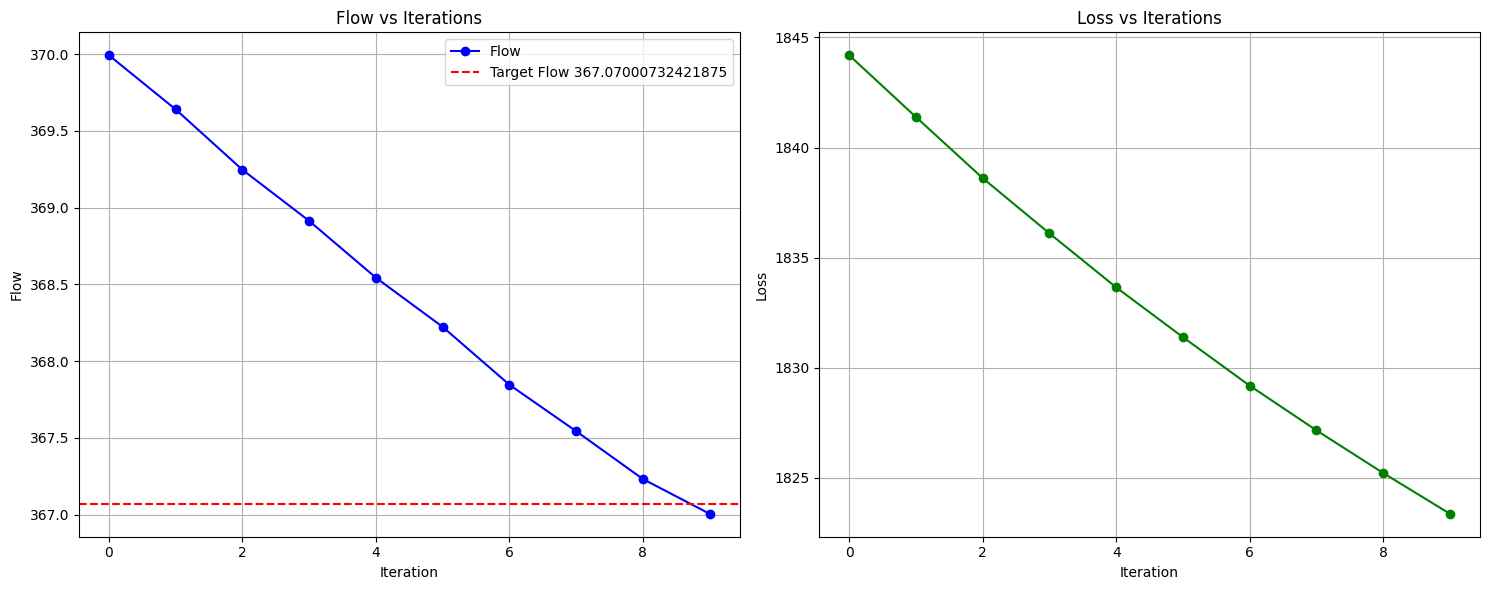

In [5]:

# Data
iterations = range(10)
# target_flow = 203.78 # 100 node
target_flow = actual_flow_val.item() # 1000 node
flow_values = flow_vals_cvxpy
loss_values = loss_vals_cvxpy

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Flow vs Iterations
ax1.plot(iterations, flow_values, 'b-', marker='o', label='Flow')
ax1.axhline(y=target_flow, color='r', linestyle='--', label=f'Target Flow {target_flow}')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Flow')
ax1.set_title('Flow vs Iterations')
ax1.grid(True)
ax1.legend()

# Plot Loss vs Iterations
ax2.plot(iterations, loss_values, 'g-', marker='o')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Loss')
ax2.set_title('Loss vs Iterations')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [5]:
print(dir(cvxpy_max_flow_layer))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_numpy', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_numpy', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters

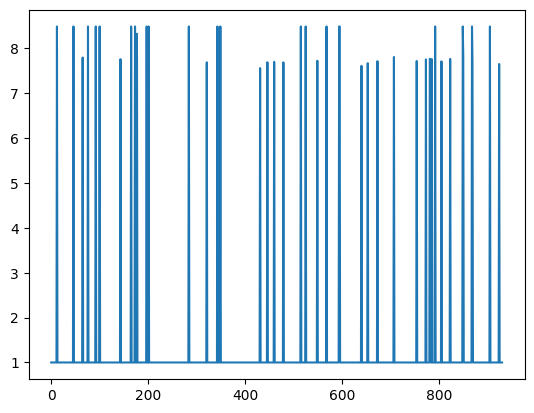

In [48]:
plt.plot(cap_var.detach().numpy())

In [3]:
## Now cook this up using Conic Zap
n_nodes = 10000
base_seed = 42
max_flow_benchmark = MaxFlowBenchmarkSet(num_problems=1, n=n_nodes, base_seed=base_seed)
for prob in max_flow_benchmark:
    problem = prob

cone_params, data, cones = get_standard_conic_problem(problem, solver=cp.CLARABEL)
cone_bridge = ConeBridge(cone_params, ruiz_iters = 0)

In [5]:
cone_params["A"].shape

(193993, 183993)

In [13]:
machine = 'cuda'
dtype = torch.float32
cone_admm_devices = [d.torchify(machine=machine, dtype=dtype) for d in cone_bridge.devices]
cone_admm_solver = ADMMSolver(
    machine=machine,
    dtype=dtype,
    atol=1e-6,
    rtol=1e-6,
    # alpha=1.6,
    # tau=2,
    adaptive_rho=False,
    num_iterations=2000,
)

parameter_names = {"cap_var": (2, "b_d")} # capacities are stored as b_d of Non. Neg Slack Devices
time_horizon = 1 
x_star = ADMMLayer(
          cone_bridge.net,
          cone_admm_devices,
          parameter_names=parameter_names,
          time_horizon=time_horizon,
          solver=cone_admm_solver,
          adapt_rho=False,
          warm_start=False,
          verbose=False
)



In [14]:
def compute_objective(st, devices, parameters):
    costs = []
    ## Hack-y we know it's just the first device
    cost = devices[0].operation_cost(st.power[0], st.phase[0], st.local_variables[0], la=torch, **parameters[0])
    # for i, d in enumerate(devices):
    #     costs += [
    #                 d.operation_cost(
    #                     st.power[i], st.phase[i], st.local_variables[i], la=torch, **parameters[i]
    #                 )
    #             ]
    
    return cost


In [15]:
n_edges = len(cone_bridge.devices[2].b_d)
mask_real = torch.ones(n_edges, dtype=torch.bool)
mask_real[-1] = False
cap_artificial  = 10000.0  
# actual_flow_val = torch.tensor(203.78) # 100 node
# actual_flow_val = torch.tensor(213.11) # 1000 node
actual_flow_val = torch.tensor(367.07) # 10000 node

lmbda = 1e-3

init = torch.tensor(cone_admm_devices[2].b_d, device="cuda").squeeze(-1)
cap_var = torch.nn.Parameter(10.0* torch.ones_like(init[mask_real])) # This doesnt include artificial edge
device = cap_var.device
optimizer = torch.optim.Adam([cap_var], lr=0.01)
admm_state = None
flow_values = []
loss_values = []

def assemble_cap(full_like_true, cap_real_vec):
    out = full_like_true.clone() # just for shape
    out[mask_real] = cap_real_vec
    out[-1] = cap_artificial
    return out

num_iters = 80
for iter in range(num_iters):
    optimizer.zero_grad()

    
    cap_full = assemble_cap(init, cap_var)
    eta = {"cap_var": cap_full}
    params = x_star.setup_parameters(**eta)


    admm_state = x_star(**eta, initial_state=None)
    flow_val = -compute_objective(admm_state, x_star.devices, params)


    loss = 0.5*(flow_val - actual_flow_val)**2 + lmbda*cap_var.sum()
    loss.backward()

    optimizer.step()

    flow_values.append(flow_val.item())
    loss_values.append(loss.item())

    # Box projection
    cap_var.data.clamp_(1.0, 10.0)
    if iter % 1 == 0:
        print(f"{iter:3d} | flow={flow_val:.4f} | loss={loss.item():.2e}")

/tmp/ipykernel_53088/4119398155.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init = torch.tensor(cone_admm_devices[2].b_d, device="cuda").squeeze(-1)


Did not converge. Ran for 2000 iterations.
  0 | flow=373.0716 | loss=1.86e+03
Did not converge. Ran for 2000 iterations.
  1 | flow=372.6592 | loss=1.85e+03
Did not converge. Ran for 2000 iterations.
  2 | flow=372.2318 | loss=1.85e+03
Did not converge. Ran for 2000 iterations.
  3 | flow=371.7902 | loss=1.85e+03
Did not converge. Ran for 2000 iterations.
  4 | flow=371.3358 | loss=1.84e+03
Did not converge. Ran for 2000 iterations.
  5 | flow=370.8701 | loss=1.84e+03
Did not converge. Ran for 2000 iterations.
  6 | flow=370.3951 | loss=1.83e+03
Did not converge. Ran for 2000 iterations.
  7 | flow=369.9145 | loss=1.83e+03
Did not converge. Ran for 2000 iterations.
  8 | flow=369.4305 | loss=1.83e+03
Did not converge. Ran for 2000 iterations.
  9 | flow=368.9492 | loss=1.83e+03
Did not converge. Ran for 2000 iterations.
 10 | flow=368.4744 | loss=1.82e+03
Did not converge. Ran for 2000 iterations.
 11 | flow=368.0122 | loss=1.82e+03
Did not converge. Ran for 2000 iterations.
 12 | flo

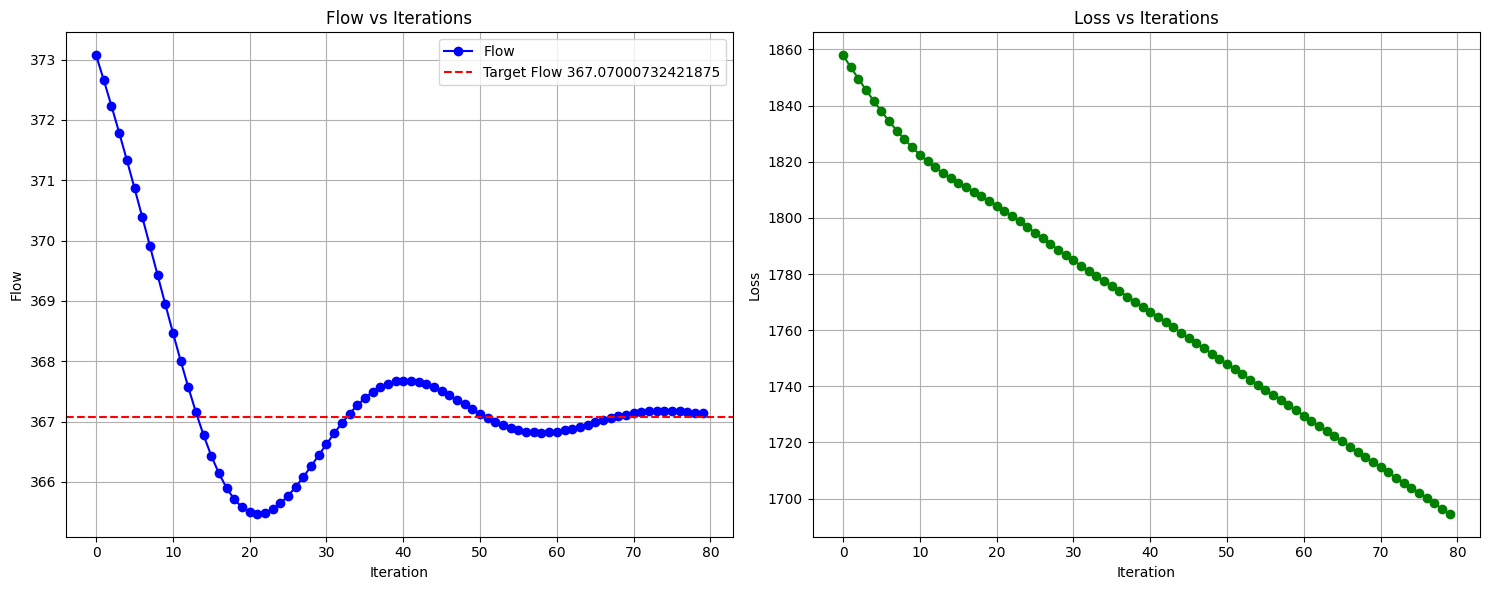

In [16]:

# Data
iterations = range(num_iters)
target_flow = actual_flow_val.item()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Flow vs Iterations
ax1.plot(iterations, flow_values, 'b-', marker='o', label='Flow')
ax1.axhline(y=target_flow, color='r', linestyle='--', label=f'Target Flow {target_flow}')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Flow')
ax1.set_title('Flow vs Iterations')
ax1.grid(True)
ax1.legend()

# Plot Loss vs Iterations
ax2.plot(iterations, loss_values, 'g-', marker='o')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Loss')
ax2.set_title('Loss vs Iterations')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [5]:
n_nodes = 100
torch.manual_seed(42)
bench = MaxFlowBenchmarkSet(num_problems=1, n=n_nodes, quad_obj=False, base_seed=42)
data = bench.get_data(0)
inc, adj, b, c, cap_true, n_edges = data
source_sink_edge_idx = int(np.argmax(c))

f = cp.Variable(n_edges)
cap = cp.Parameter(n_edges, nonneg=True)
constraints = []
constraints.append(f <= cap)
constraints.append(inc @ f == b)
obj = c @ f
problem = cp.Problem(cp.Minimize(-obj), constraints)
parameters = [cap]


probdata, chain, inverse_data = problem.get_problem_data(solver=cp.CLARABEL)
data = {
        "P": probdata.get("P", None),
        "A": probdata["A"],
        "b": probdata["b"],
        "c": probdata["c"],
    }
cone_dims = probdata["dims"]
cones = {
    "z": cone_dims.zero,
    "l": cone_dims.nonneg,
    "q": cone_dims.soc,
    "ep": cone_dims.exp,
    "s": cone_dims.psd,
}
cone_params = {
    "P": probdata.get("P", None),
    "A": probdata["A"],
    "b": probdata["b"],
    "c": probdata["c"],
    "K": cones,
}
inverse_data


 (),
 {'var_id': 23,
  'dims': (zero: 100, nonneg: 932, exp: 0, soc: [], psd: [], p3d: []),
  'eq_constr': [Zero(Expression(AFFINE, UNKNOWN, (100,)))],
  'other_constr': [NonNeg(Expression(AFFINE, UNKNOWN, (932,)))],
  'offset': array(0.)}]

In [31]:
cap.value()

TypeError: 'numpy.ndarray' object is not callable

In [13]:
compiler = probdata[cp.settings.PARAM_PROB]
print(dir(compiler.reduced_P))
print(compiler.reduced_A.matrix_data)


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'cache', 'get_matrix_from_tensor', 'mapping_nonzero', 'matrix_data', 'problem_data_index', 'quad_form', 'reduced_mat', 'var_len']
<COOrdinate sparse matrix of dtype 'float64'
	with 3728 stored elements and shape (962856, 933)>
  Coords	Values
  (67080, 932)	-1.0
  (147576, 932)	-1.0
  (182664, 932)	-1.0
  (331272, 932)	-1.0
  (444792, 932)	-1.0
  (460272, 932)	-1.0
  (474720, 932)	-1.0
  (494328, 932)	-1.0
  (566568, 932)	-1.0
  (660480, 932)	-1.0
  (673896, 932)	-1.0
  (694536, 932)	-1.0
  (729624, 932)	-1.0
  (778128, 932)	-1.0
  (797736, 932)	-1.0
  (805992, 932)	-1.0
  (807024, 932)	-1.0
  (810120, 932)	-1.0
  (830760, 932)	-1.

In [56]:
def map_cvxpy_parameters_to_cone_program(problem, parameters, solver=cp.CLARABEL):
    """
    TODO: Re-write this function to not do the difference of applications eventually.
    """    
    probdata, chain, inverse_data = problem.get_problem_data(solver=solver)
    compiler = probdata[cp.settings.PARAM_PROB]
    
    has_quadratic_obj = compiler.reduced_P.matrix_data is not None
    
    # Create parameter mappings using the difference method
    param_mappings = {}
    for i, param in enumerate(parameters):
        param_name = param.name()
        param_id = param.id
        
        # Store original parameter value
        original_value = param.value
        
        # Create test values that preserve the shape of the parameter
        if param.shape == ():  # Scalar parameter
            test_value1 = 1.0
            test_value2 = 0.0
        else:
            # Create array with the correct shape
            test_value1 = np.ones(param.shape)
            test_value2 = np.zeros(param.shape)
        
        # Get problem data with first test value
        param.value = test_value1
        if has_quadratic_obj:
            P1, c1, d1, A1, b1 = compiler.apply_parameters(quad_obj=True)
        else:
            c1, d1, A1, b1 = compiler.apply_parameters(quad_obj=False)
            P1 = None
        
        # Get problem data with second test value
        param.value = test_value2
        if has_quadratic_obj:
            P2, c2, d2, A2, b2 = compiler.apply_parameters(quad_obj=True)
        else:
            c2, d2, A2, b2 = compiler.apply_parameters(quad_obj=False)
            P2 = None
        
        # Restore original parameter value
        param.value = original_value
        
        # Find differences in vectors and matrices
        c_diff = np.where(c1 != c2)[0].tolist()
        b_diff = np.where(b1 != b2)[0].tolist()
        d_affected = d1 != d2  # Boolean indicating if d is affected

        
        # Handle sparse A matrix
        if sp.issparse(A1):
            A_diff = (A1 != A2).nonzero()
            A_affected = list(zip(A_diff[0].tolist(), A_diff[1].tolist()))
        else:
            A_diff = np.where(A1 != A2)
            A_affected = list(zip(A_diff[0].tolist(), A_diff[1].tolist()))
        
        # Handle P matrix if it exists
        P_affected = []
        if P1 is not None and P2 is not None:
            if sp.issparse(P1):
                P_diff = (P1 != P2).nonzero()
                P_affected = list(zip(P_diff[0].tolist(), P_diff[1].tolist()))
            else:
                P_diff = np.where(P1 != P2)
                P_affected = list(zip(P_diff[0].tolist(), P_diff[1].tolist()))
        
        # Create mapping dictionary
        param_mappings[param_name] = {
            'id': param_id,
            'size': param.size,
            'param_col': compiler.param_id_to_col.get(param_id, None),
            'affects_c': c_diff,
            'affects_b': b_diff,
            'affects_A': A_affected,
            'affects_P': P_affected,
            'affects_d': d_affected

        }
    
    return param_mappings

In [34]:
def test_parameter_mapping():
    test_cases = []
    
    # Test Case 1: Network flow problem with parameterized capacities
    def create_test_case_1():
        n_nodes = 10
        np.random.seed(42)
        
        # Create a random directed graph
        edges = []
        for i in range(n_nodes):
            for j in range(n_nodes):
                if i != j and np.random.rand() < 0.3:
                    edges.append((i, j))
        
        n_edges = len(edges)
        
        # Create incidence matrix
        inc = np.zeros((n_nodes, n_edges))
        for e_idx, (i, j) in enumerate(edges):
            inc[i, e_idx] = 1   # Outgoing
            inc[j, e_idx] = -1  # Incoming
        
        # Source and sink
        source = 0
        sink = n_nodes - 1
        
        # Flow balance
        b = np.zeros(n_nodes)
        b[source] = 1   # Source produces 1 unit
        b[sink] = -1    # Sink consumes 1 unit
        
        # Flow variables and capacity parameters
        f = cp.Variable(n_edges)
        capacity = cp.Parameter(n_edges, nonneg=True)
        
        # Objective: maximize flow
        c = np.zeros(n_edges)
        for e_idx, (i, j) in enumerate(edges):
            if j == sink:
                c[e_idx] = 1  # Maximize flow into sink
        
        # Constraints
        constraints = [
            f >= 0,               # Non-negative flow
            f <= capacity,        # Capacity constraints
            inc @ f == b          # Flow conservation
        ]
        
        objective = cp.Maximize(c @ f)
        problem = cp.Problem(objective, constraints)
        
        # Initialize capacity parameters
        capacity.value = np.random.uniform(0.5, 2.0, n_edges)
        
        return problem, [capacity], "Network flow with parameterized capacities"
    
    # Test Case 2: Portfolio optimization with parameterized expected returns
    def create_test_case_2():
        n_assets = 10
        np.random.seed(43)
        
        # Covariance matrix (fixed)
        Sigma = np.random.randn(n_assets, n_assets)
        Sigma = Sigma.T @ Sigma  # Make positive semidefinite
        
        # Expected returns (parameterized)
        mu = cp.Parameter(n_assets)
        
        # Portfolio weights
        w = cp.Variable(n_assets)
        
        # Objective: maximize return - lambda * risk
        risk_aversion = 0.1
        objective = cp.Maximize(mu @ w - risk_aversion * cp.quad_form(w, Sigma))
        
        # Constraints
        constraints = [
            cp.sum(w) == 1,   # Fully invested
            w >= 0            # Long only
        ]
        
        problem = cp.Problem(objective, constraints)
        
        # Initialize expected returns
        mu.value = np.random.uniform(0.05, 0.15, n_assets)
        
        return problem, [mu], "Portfolio optimization with parameterized returns"
    
    # Test Case 3: Support Vector Machine with parameterized regularization
    def create_test_case_3():
        n_samples = 20
        n_features = 5
        np.random.seed(44)
        
        # Generate random data
        X = np.random.randn(n_samples, n_features)
        y = np.sign(np.random.randn(n_samples))  # Binary labels (-1, 1)
        
        # Model parameters
        w = cp.Variable(n_features)
        b = cp.Variable()
        
        # Regularization parameter (this is what we're parameterizing)
        C = cp.Parameter(nonneg=True)
        
        # Slack variables for soft margin
        slack = cp.Variable(n_samples)
        
        # Constraints
        constraints = [
            cp.multiply(y, X @ w + b) >= 1 - slack,
            slack >= 0
        ]
        
        # Objective: minimize ||w||^2 + C * sum(slack)
        objective = cp.Minimize(cp.sum_squares(w) + C * cp.sum(slack))
        problem = cp.Problem(objective, constraints)
        
        # Initialize regularization parameter
        C.value = 1.0
        
        return problem, [C], "SVM with parameterized regularization"
    
    # Test Case 4: Optimal control with parameterized control costs
    def create_test_case_4():
        # Simple linear dynamical system
        n_states = 3
        n_controls = 2
        n_timesteps = 5
        
        # System matrices
        A = np.eye(n_states) + 0.1 * np.random.randn(n_states, n_states)
        B = np.random.randn(n_states, n_controls)
        
        # Initial state
        x0 = np.ones(n_states)
        
        # State and control variables
        x = [cp.Variable(n_states) for _ in range(n_timesteps+1)]
        u = [cp.Variable(n_controls) for _ in range(n_timesteps)]
        
        # Control cost parameters (what we're parameterizing)
        R = cp.Parameter((n_controls, n_controls), PSD=True)
        
        # State cost (fixed)
        Q = np.eye(n_states)
        
        # Constraints: dynamics and initial condition
        constraints = [x[0] == x0]
        for t in range(n_timesteps):
            constraints.append(x[t+1] == A @ x[t] + B @ u[t])
        
        # Objective: minimize sum of quadratic costs
        objective = 0
        for t in range(n_timesteps):
            objective += cp.quad_form(x[t], Q) + cp.quad_form(u[t], R)
        objective += cp.quad_form(x[n_timesteps], Q)  # Terminal cost
        
        problem = cp.Problem(cp.Minimize(objective), constraints)
        
        # Initialize control cost matrix
        R_val = np.random.randn(n_controls, n_controls)
        R_val = R_val.T @ R_val  # Make PSD
        R.value = R_val
        
        return problem, [R], "Optimal control with parameterized control costs"
    
    # Test Case 5: Resource allocation with multiple parameters
    def create_test_case_5():
        n_resources = 4
        n_tasks = 6
        
        # Resource allocation variables
        x = cp.Variable((n_tasks, n_resources))
        
        # Parameters:
        # - task_benefit: benefit of completing each task
        # - resource_cost: cost of using each resource
        # - resource_limit: maximum available amount of each resource
        task_benefit = cp.Parameter(n_tasks, nonneg=True)
        resource_cost = cp.Parameter(n_resources, nonneg=True)
        resource_limit = cp.Parameter(n_resources, nonneg=True)
        
        # Resource consumption matrix (fixed)
        consumption = np.random.uniform(0.1, 1.0, (n_tasks, n_resources))
        
        # Constraints
        constraints = [
            x >= 0,  # Non-negative allocation
            cp.sum(x, axis=0) <= resource_limit,  # Resource limits
            cp.sum(x, axis=1) <= 1  # At most 100% allocation per task
        ]
        
        # Objective: maximize task benefits - resource costs
        objective = cp.Maximize(
            task_benefit @ cp.sum(x, axis=1) - resource_cost @ cp.sum(x, axis=0)
        )
        
        problem = cp.Problem(objective, constraints)
        
        # Initialize parameters
        task_benefit.value = np.random.uniform(5, 10, n_tasks)
        resource_cost.value = np.random.uniform(1, 3, n_resources)
        resource_limit.value = np.random.uniform(2, 4, n_resources)
        
        return problem, [task_benefit, resource_cost, resource_limit], "Resource allocation with multiple parameters"
    
    test_cases = [
        create_test_case_1(),
        create_test_case_2(),
        create_test_case_3(),
        create_test_case_4(),
        create_test_case_5()
    ]
    
    return test_cases

In [57]:
def verify_parameter_mapping(problem, parameters, param_mappings):
    """
    Verifies if the parameter mappings correctly identify which elements
    change when parameter values are modified.
    """
    # Get problem data and compiler
    probdata, _, _ = problem.get_problem_data(solver=cp.CLARABEL)
    compiler = probdata[cp.settings.PARAM_PROB]
    
    # Check if we have a quadratic objective
    has_quadratic_obj = hasattr(compiler, 'reduced_P') and compiler.reduced_P is not None and \
                        hasattr(compiler.reduced_P, 'matrix_data') and compiler.reduced_P.matrix_data is not None
    
    results = {}
    
    for i, param in enumerate(parameters):
        param_name = param.name()
        mapping = param_mappings[param_name]
        
        # Store original value
        original_value = param.value
        
        # Create a test value with the same shape but different values
        if param.shape == ():  # Scalar parameter
            test_value = 2.0  # Different from both 0.0 and 1.0 used in mapping
        else:
            # Create test value with different values from those used in mapping
            test_value = np.full(param.shape, 2.0)
        
        # Get original problem data with original parameter value
        if has_quadratic_obj:
            P_orig, c_orig, d_orig, A_orig, b_orig = compiler.apply_parameters(quad_obj=True)
        else:
            c_orig, d_orig, A_orig, b_orig = compiler.apply_parameters(quad_obj=False)
            P_orig = None
        
        # Change parameter value
        param.value = test_value
        
        # Get new problem data with changed parameter value
        if has_quadratic_obj:
            P_new, c_new, d_new, A_new, b_new = compiler.apply_parameters(quad_obj=True)
        else:
            c_new, d_new, A_new, b_new = compiler.apply_parameters(quad_obj=False)
            P_new = None
        
        # Reset parameter value
        param.value = original_value
        
        # Find actual differences
        c_diff_actual = np.where(c_new != c_orig)[0].tolist()
        b_diff_actual = np.where(b_new != b_orig)[0].tolist()
        d_affected_actual = d_new != d_orig
        
        # A might be sparse
        if sp.issparse(A_new):
            A_diff = (A_new != A_orig).nonzero()
            A_diff_actual = list(zip(A_diff[0].tolist(), A_diff[1].tolist()))
        else:
            A_diff = np.where(A_new != A_orig)
            A_diff_actual = list(zip(A_diff[0].tolist(), A_diff[1].tolist()))
        
        # P might be sparse and might not exist
        P_diff_actual = []
        if P_new is not None and P_orig is not None:
            if sp.issparse(P_new):
                P_diff = (P_new != P_orig).nonzero()
                P_diff_actual = list(zip(P_diff[0].tolist(), P_diff[1].tolist()))
            else:
                P_diff = np.where(P_new != P_orig)
                P_diff_actual = list(zip(P_diff[0].tolist(), P_diff[1].tolist()))
        
        # Get predicted differences from our mapping
        b_diff_predicted = mapping['affects_b']
        c_diff_predicted = mapping['affects_c']
        A_diff_predicted = mapping['affects_A']
        P_diff_predicted = mapping['affects_P']
        d_affected_predicted = mapping['affects_d']
        
        # Compare actual vs predicted
        b_correct = set(b_diff_actual) == set(b_diff_predicted)
        c_correct = set(c_diff_actual) == set(c_diff_predicted)
        A_correct = set(A_diff_actual) == set(A_diff_predicted)
        P_correct = set(P_diff_actual) == set(P_diff_predicted)
        d_correct = d_affected_actual == d_affected_predicted
        
        # Store results
        results[param_name] = {
            'b_correct': b_correct,
            'c_correct': c_correct,
            'A_correct': A_correct,
            'P_correct': P_correct,
            'd_correct': d_correct,
            'overall_correct': b_correct and c_correct and A_correct and P_correct and d_correct,
            # Include the actual vs predicted for debugging
            'b_actual': b_diff_actual,
            'b_predicted': b_diff_predicted,
            'c_actual': c_diff_actual, 
            'c_predicted': c_diff_predicted,
            'A_actual': A_diff_actual,
            'A_predicted': A_diff_predicted,
            'P_actual': P_diff_actual,
            'P_predicted': P_diff_predicted,
            'd_actual': d_affected_actual,
            'd_predicted': d_affected_predicted
        }
    
    return results

In [58]:
def run_parameter_mapping_tests():
    """Run tests on parameter mapping with various problem types"""
    test_cases = test_parameter_mapping()
    overall_success = True
    
    for problem, parameters, description in test_cases:
        print(f"\n===== Testing: {description} =====")
        
        # Get parameter mappings using our function
        param_mappings = map_cvxpy_parameters_to_cone_program(problem, parameters)
        
        # Verify mappings
        verification_results = verify_parameter_mapping(problem, parameters, param_mappings)
        
        # Print results
        case_success = True
        for param_name, result in verification_results.items():
            print(f"\nParameter '{param_name}':")
            
            # Report on each matrix/vector
            for component in ['b', 'c', 'A', 'P']:
                correct = result[f'{component}_correct']
                print(f"  {component} mapping correct: {correct}")
                
                if not correct:
                    case_success = False
                    print(f"    Actual indices: {result[f'{component}_actual']}")
                    print(f"    Predicted indices: {result[f'{component}_predicted']}")
            
            print(f"  Overall mapping correct: {result['overall_correct']}")
        
        print(f"\nTest case {'PASSED' if case_success else 'FAILED'}")
        overall_success = overall_success and case_success
    
    print(f"\n===== Overall {'PASSED' if overall_success else 'FAILED'} =====")
    return overall_success

run_parameter_mapping_tests()


===== Testing: Network flow with parameterized capacities =====

Parameter 'param746':
  b mapping correct: True
  c mapping correct: True
  A mapping correct: True
  P mapping correct: True
  Overall mapping correct: True

Test case PASSED

===== Testing: Portfolio optimization with parameterized returns =====

Parameter 'param762':
  b mapping correct: True
  c mapping correct: True
  A mapping correct: True
  P mapping correct: True
  Overall mapping correct: True

Test case PASSED

===== Testing: SVM with parameterized regularization =====

Parameter 'param781':
  b mapping correct: True
  c mapping correct: True
  A mapping correct: True
  P mapping correct: True
  Overall mapping correct: True

Test case PASSED

===== Testing: Optimal control with parameterized control costs =====

Parameter 'param814':
  b mapping correct: True
  c mapping correct: True
  A mapping correct: True
  P mapping correct: True
  Overall mapping correct: True

Test case PASSED

===== Testing: Resource

/home/groups/ramr/akshay81/poetry_cache/virtualenvs/zap-eFcx8M23-py3.12/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


True